# A transpiler demonstrator

This workbook gives a simple example of how a model in a simple business logic language can be transpiled to a Python function. 

It don't depend on Modelflow. The purpose is to illustrate how to use Python to write a Python program which can solve a model on data in a Pandas DataFrame

The Workbook shows how expressions are tokenized, and how a list of tokens can be used to manufacture a python function. 
This function can then be used to evaluate the expressions (the model).

In this mini business logic language time (t) is implicit. only lags [(-<lag>)] need to be specified. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pandas as pd

The transpiler consists of two phases
-------------------------------------
- Tokenize an expressions into terms 
- recombining the terms as legal python code. But substitution **var** -\> dataframe.loc[periode+lag,**var**]  

This will access the relevant row and column in a Pandas dataframe 

## A model is a collection of expressions 

In [2]:
fmodel      = '''\
a = b+c(-1) 
d = a+ (x(-1)) 
x = a+b '''
print(fmodel)

a = b+c(-1) 
d = a+ (x(-1)) 
x = a+b 


## To tokenizer
Using Regular expressions

In [3]:
expression ='a  =b+c(-1)+log(10)'

funkname    = ['LOG'] # names of functions 
funkname2   = [i+r'(?=\()' for i in funkname]                                 # a function is followed by a (, ?= is positive lookahead 
opname      = r'[=+-]'.split()                                                # list of ordinary operators 
oppat       = '('+'|'.join(['(?:' + i + ')' for i in funkname2+opname])+')'   # the pattern for operators 
numpat      = r'([0-9]+)'                                                     # the pattern for a number 
namepat     = r'([A-Z][A-Z0-9_]*)' # a name                                      # the pattern for a variable name 
lagpat      = r'(?:\(([+-][0-9]+)\))?'                                        # the pattern for a lag or lead 

parsepat = numpat + '|' + oppat + '|' + namepat + lagpat
xxx    = re.findall(parsepat  ,  expression.upper())  # the actual parsing 

from collections import namedtuple
nterm  = namedtuple('nterm', [ 'number', 'op', 'var', 'lag'])
ibh = [nterm._make(t) for t in xxx]   # Easier to remember by using named tupels . 
ibh

[nterm(number='', op='', var='A', lag=''),
 nterm(number='', op='=', var='', lag=''),
 nterm(number='', op='', var='B', lag=''),
 nterm(number='', op='+', var='', lag=''),
 nterm(number='', op='', var='C', lag='-1'),
 nterm(number='', op='+', var='', lag=''),
 nterm(number='', op='LOG', var='', lag=''),
 nterm(number='10', op='', var='', lag='')]

In [4]:
parsepat

'([0-9]+)|((?:LOG(?=\\())|(?:[=+-]))|([A-Z][A-Z0-9_]*)(?:\\(([+-][0-9]+)\\))?'

## Now we are in business, lets make af function which can tokenize

In [5]:
def expression_tokenize(expression):
    from collections import namedtuple
    
    funkname    = 'DLOG LOG DIFF EXP MIN MAX MATRIX MV_OPT MV_OPT_PROP TRANS FLOAT SUM_EXCEL'.split() # names of functions 
    funkname2   = [i+r'(?=\()' for i in funkname]                                 # a function is followed by a (, ?= is positive lookahead 
    opname      = r'\*\*  >=  <=  ==  [=+-/*()$><,.\]\[]'.split()                 # list of ordinary operators 
    oppat       = '('+'|'.join(['(?:' + i + ')' for i in funkname2+opname])+')'   # the pattern for operators 
    numpat      = r'((?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]\d+)?)'                    # the pattern for a number 
    namepat     = r'([A-Za-z_]\w*)' # a name                                      # the pattern for a variable name 
    lagpat      = r'(?:\(([+-][0-9]+)\))?'                                        # the pattern for a lag or lead 
    
    temp   = re.sub(r'\s+', '', expression.upper()) # remove all blanks 
    
    xxx    = re.findall( numpat + '|' + oppat + '|' + namepat + lagpat , temp)  # the actual parsing 
    nterm  = namedtuple('nterm', [ 'number', 'op', 'var', 'lag'])
    ibh = [nterm._make(t) for t in xxx]   # Easier to remember by using named tupels . 
    return ibh

## Example of output from tokenizer 
A list of lists of terms 

In [6]:
termslist = [expression_tokenize(i) for i in fmodel.split('\n')]
termslist

[[nterm(number='', op='', var='A', lag=''),
  nterm(number='', op='=', var='', lag=''),
  nterm(number='', op='', var='B', lag=''),
  nterm(number='', op='+', var='', lag=''),
  nterm(number='', op='', var='C', lag='-1')],
 [nterm(number='', op='', var='D', lag=''),
  nterm(number='', op='=', var='', lag=''),
  nterm(number='', op='', var='A', lag=''),
  nterm(number='', op='+', var='', lag=''),
  nterm(number='', op='(', var='', lag=''),
  nterm(number='', op='', var='X', lag='-1'),
  nterm(number='', op=')', var='', lag='')],
 [nterm(number='', op='', var='X', lag=''),
  nterm(number='', op='=', var='', lag=''),
  nterm(number='', op='', var='A', lag=''),
  nterm(number='', op='+', var='', lag=''),
  nterm(number='', op='', var='B', lag='')]]

## Create a function which creates a factory function 

In [7]:
def output(t):
    '''This function returns a python term '''
    return t.op.lower() if t.op else t.number if t.number else "df.loc[periode" + t.lag + ",'"+t.var+"']"

def xouteval(termslist):
    ''' takes a list of terms and translates to a evaluater function called los    
    
    Basicly var(lag) is translated to: Dataframe.loc[<periode>+<lag>,<name>]    
    '''
    fib2=[]
    short = ' ' *7 
    fib='''\
def make_los():
  from math import exp, log
  def los(df,periode):\n'''
    uib = '\n'.join([ short+''.join([output(t)  for t in terms]) for terms in termslist])
    fib2.append('\n'+ short +'return \n')
    fib2.append('  return los\n')
    return (''.join(fib)) +uib + ''.join(fib2)

In [8]:
modelterms = [expression_tokenize(i) for i in fmodel.split('\n')]  # tokenize the expressions in the model 
text       = xouteval(modelterms)                     # Create the text for the factory function 
exec(text)                                           # Execute the text to create the factory function 
calc     = make_los()                               # Execute the factory function to get the calculation function 

print(f'Model:\n{fmodel}\n')
print(f'And the resulting calculating function: \n{text}')

Model:
a = b+c(-1) 
d = a+ (x(-1)) 
x = a+b 

And the resulting calculating function: 
def make_los():
  from math import exp, log
  def los(df,periode):
       df.loc[periode,'A']=df.loc[periode,'B']+df.loc[periode-1,'C']
       df.loc[periode,'D']=df.loc[periode,'A']+(df.loc[periode-1,'X'])
       df.loc[periode,'X']=df.loc[periode,'A']+df.loc[periode,'B']
       return 
  return los



# Now create some data 

In [9]:
import pandas as pd
dates= [2015,2016,2017,2018]
df = pd.DataFrame({'B': [1,1,1,1],'C':[1,2,3,4],'X':[4,4,4,4]},index=dates)
df['A']=0
df['D']=0
print(df)

      B  C  X  A  D
2015  1  1  4  0  0
2016  1  2  4  0  0
2017  1  3  4  0  0
2018  1  4  4  0  0


In [10]:
print(fmodel)    # so we remember the model 

a = b+c(-1) 
d = a+ (x(-1)) 
x = a+b 


In [11]:
for d in dates[1:]:     # we have to start at period 1 as there is a lag 
    calc(df,d)
print(df)

      B  C  X  A  D
2015  1  1  4  0  0
2016  1  2  3  2  6
2017  1  3  4  3  6
2018  1  4  5  4  8


## Find dependecies  
For each left hand side variable find all the variables on the right hand side

In [12]:
causal={termslist[0].var: 
         set([term.var for term in termslist if term.var][1:])
         for termslist in modelterms }
print(causal)

{'A': {'C', 'B'}, 'D': {'X', 'A'}, 'X': {'B', 'A'}}


## Create causality graph

In [13]:
import networkx as nx
gall   = nx.DiGraph()
for endo,rhv  in causal.items() :
    for v in rhv:
        gall.add_edge(v,endo)

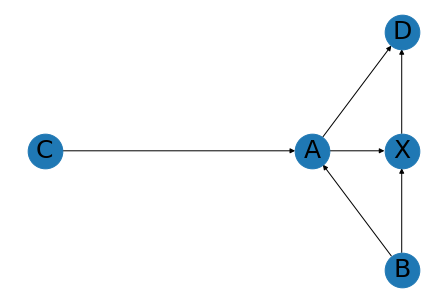

In [14]:
pos=nx.spectral_layout(gall) 
nx.draw(gall,pos=pos,node_size=1200)
nx.draw_networkx_labels(gall,pos=pos,font_size=25)
plt.show()        

# Find all endogeneous and exogeneous variables 

In [15]:
all_var  = set([v.var for e in modelterms for v in e if v.var])
print(all_var)

{'C', 'A', 'B', 'D', 'X'}


In [16]:
endo_var = set([e[0].var for e in modelterms ])
print(endo_var)

{'D', 'X', 'A'}


In [17]:
exo_var = all_var - endo_var
print(exo_var)

{'C', 'B'}


## This not all  
This was an simple example. To get a really useful model evaluater/solver we need more: 

-  Syntax chekking 
-  Error catching 
-  Real speedup 
-  Equation Sequencing 

Python makes theese tasks easy to perform. 